First, load the data,in this notebook we are using the smokoy mountain data as the example.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle
import matplotlib.pyplot as plt

### 1. Load the data and data preprocess
After reading the data, convert the abundance matrix into relative abundance matrix; for the response variables, since we have multiple variables, organize them into an array with each variable as a column.

In [3]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [4]:
data

array([[1.5786533e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6912335e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0700000e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.2400000e-05, 8.2400000e-05],
       [1.5771320e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [5]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [6]:
# abundance matrix--> relative abundance matrix


In [7]:
yList= np.column_stack((burn_label,un_label,duration_label))# y list is a 2D array, each column is a response outcome

In [8]:
y_index=['burn_label', 'un_label', 'duration_label']

### 2. Kruskal-Wallis H-test on OTUs for each response variable.


In [9]:
# calculating H score for each OTU, the function will: 1. filter those below threshold (1%) to 0; 2. rank the data; calculate the H statistics
weights=FS.OTU_H_Score_fun(data,yList)

In [10]:
weights.shape

(3, 1768)

#### Examine  the H statistics results
As a result, will continue to use the "union" of the features that are selected each response variable.

In [11]:
from scipy import stats
df1 = pd.DataFrame(weights, index=['burn_label', 'un_label', 'duration_label'])
columns_sig = (df1 > stats.chi2.ppf(0.9, 1)).any()
# Count the number of columns where at least one value is larger than 0
count = columns_sig.sum()
print(count)
count_larger= (df1 > stats.chi2.ppf(0.9, 1)).sum(axis=1)

# Display the result
print("Number of H statistics larger than significance cutoff (p =10%) in each response variable:")
print(count_larger)

203
Number of H statistics larger than significance cutoff (p =10%) in each response variable:
burn_label        141
un_label           79
duration_label     26
dtype: int64


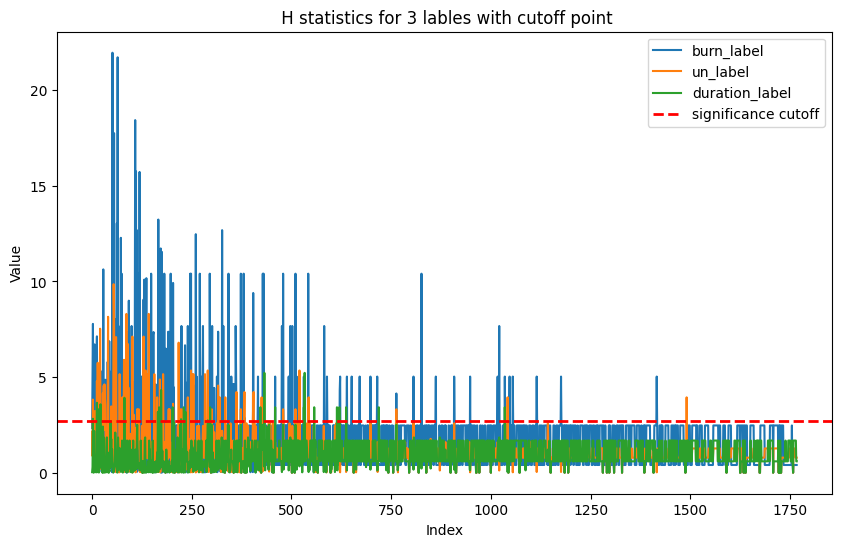

In [12]:
import matplotlib.pyplot as plt
# Plotting each row individually
plt.figure(figsize=(10, 6))
for row in df1.index:
    plt.plot(df1.columns, df1.loc[row], label=row)

# Add a horizontal line at y=0
plt.axhline(y=2.705543454095404, color='red', linestyle='--', linewidth=2, label='significance cutoff')

# Set plot title and labels
plt.title(' H statistics for 3 lables with cutoff point')
plt.xlabel('Index')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()

### 3. Select indices of the features based on H statistics and form the subset based on the selected features.
The default p value of the function is 10%, the resulted index is ranked by its H statistics descendingly.

Use "indice_H_unisig" if there is only one response, use "indice_H_multisig" for multiple responses.

In [13]:
selectedOTU_index, eps=FS.indice_H_multisig(weights,yList)
print(eps)

203


In [14]:
# the subset based on the method.
X_FS = data[:,selectedOTU_index]

In [15]:
#plot the h statistics and cutoff descendingly
# FS.plotWeightedIndex(weights,threshold=eps)

In [16]:
# Calculate the sum of each column
col_sums = np.sum(weights, axis=0)

# Get the sorted indices of the columns based on the column sums
sorted_indices = np.argsort(-col_sums)

# Sort the columns of the array based on the sorted indices
sorted_weights = weights[:, sorted_indices]

In [17]:
sorted_weights[0,100:120]

array([5.89262923, 6.70963194, 5.02636917, 5.02636917, 5.02636917,
       5.02636917, 5.02636917, 1.247043  , 4.70720557, 4.14238225,
       4.56977634, 6.87693184, 1.17680139, 6.72152596, 2.43087091,
       1.7047326 , 3.23897703, 1.25663882, 1.25663882, 5.2760565 ])

In [18]:
y_index=['burn_label', 'un_label', 'duration_label']

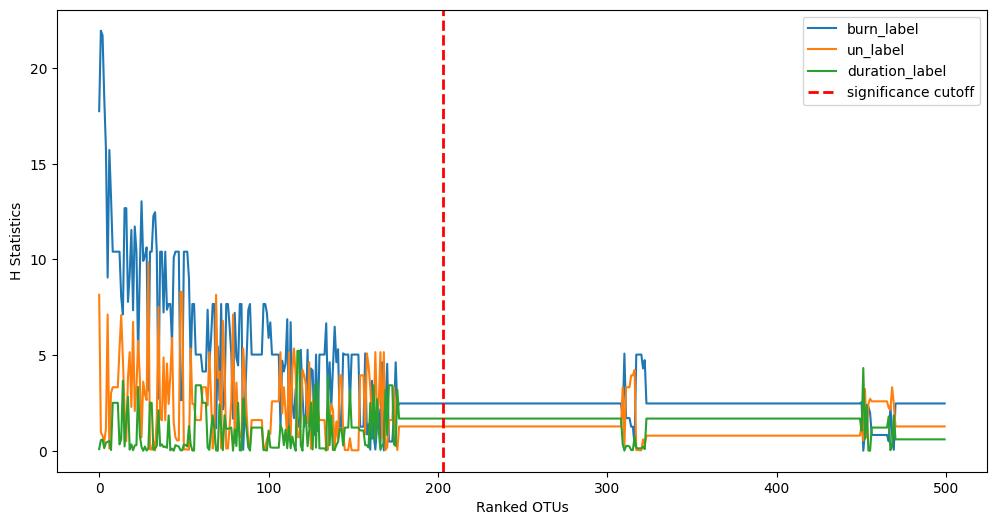

In [19]:
# Plot each row as a line
# plt.figure(dpi=300)
plt.figure(figsize=(12, 6))
for i, row in enumerate(sorted_weights[:,0:500]):
    plt.plot(row,label=y_index[i])

# Adding labels and legend
# Add a horizontal line at y=0
plt.axvline(x=eps, color='red', linestyle='--', linewidth=2, label='significance cutoff')
plt.xlabel('Ranked OTUs')
plt.ylabel('H Statistics')
plt.legend()
plt.show()

### Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [20]:
iter =30
cls = ["RF","SVM"]

In [21]:
un_label.value_counts()
targetLabel=un_label

In [22]:
X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
print(xlabel_lasso)
X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)
print(xlabel_lasso_ft)

[  35   36   40   45   58   60   73   76   85   86   89   94  104  105
  111  118  133  166  222  264  290  303  309  312  320  331  346  350
  353  363  378  396  405  413  469  475  478  499  512  520  536  539
  560  571  573  591  594  606  612  616  617  619  620  629  636  643
  661  666  675  692  694  704  726  732  733  737  757  775  780  781
  798  816  817  823  830  833  849  853  854  901  916  972 1063 1118
 1143 1147 1180 1190 1192 1273 1339 1340 1347 1407 1423 1424 1460 1505
 1506 1548 1558 1559 1560 1618 1619 1620 1621 1666 1688 1700 1701 1702
 1703 1704]
Best alpha: 0.1
[ 14  29  40  60  86  89 111 133 166 320 520 543 849]


In [23]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft,
               "Random":data
              }

In [24]:
print(np.shape(data))
print(np.shape(X_FS))
print(np.shape(X_lasso))
print(np.shape(X_lasso_ft))

(59, 1768)
(59, 203)
(59, 114)
(59, 13)


The  function will print out the accuracy and AUC for each dataset using each classifier, and also will return the y_actual, y_predict, y_predprob for future use.

In [25]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)

Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <clas

In [26]:
# Save dictionary to a pickle file
#with open('../results/dict_cm_smocky_un.pkl', 'wb') as pickle_file:
    #pickle.dump(dict_cm, pickle_file)
# Load dictionary from the pickle file
#with open('../results/dict_cm_smocky_un.pkl', 'rb') as pickle_file:
    #dict_cm = pickle.load(pickle_file)

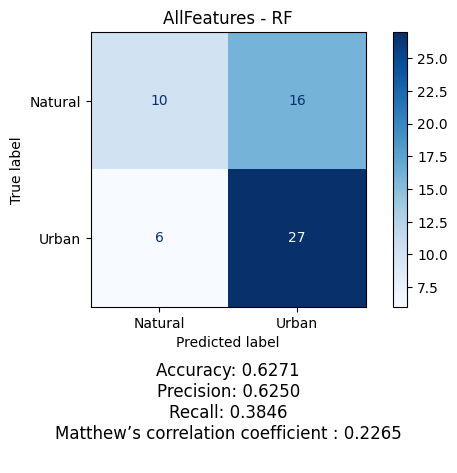

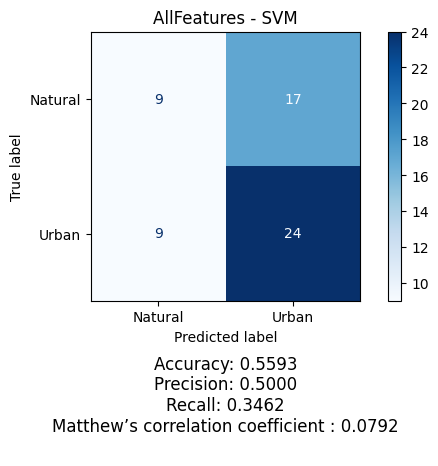

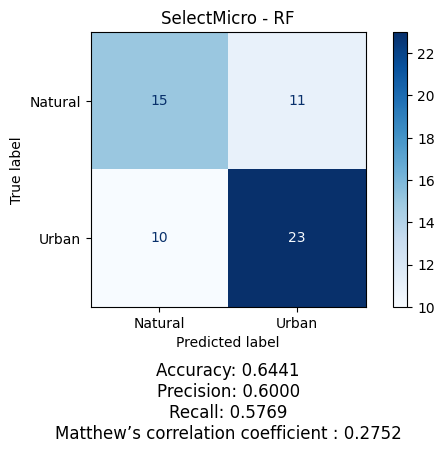

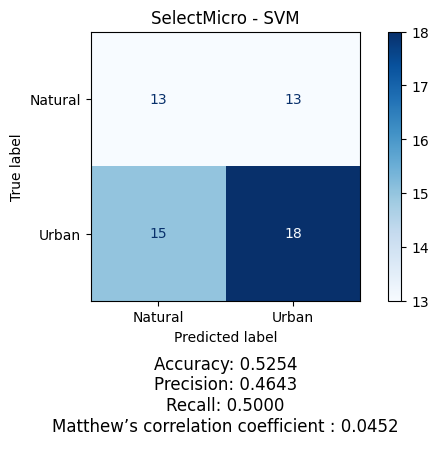

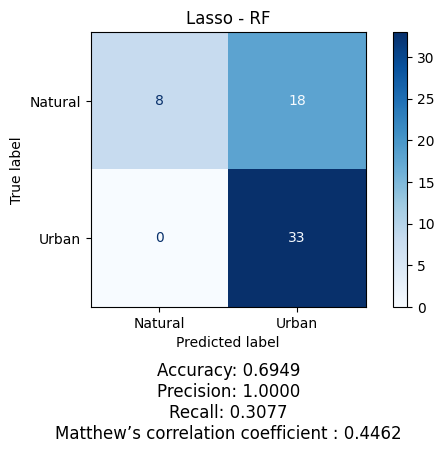

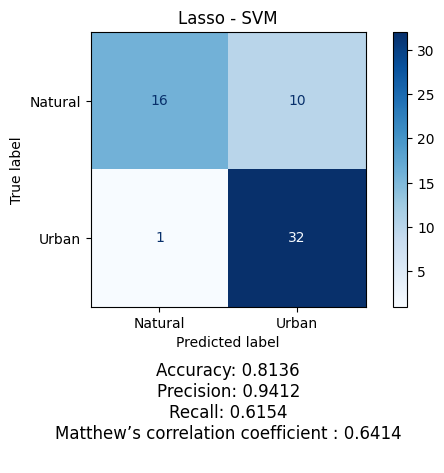

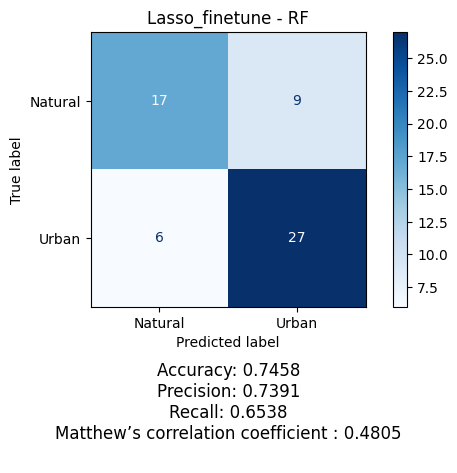

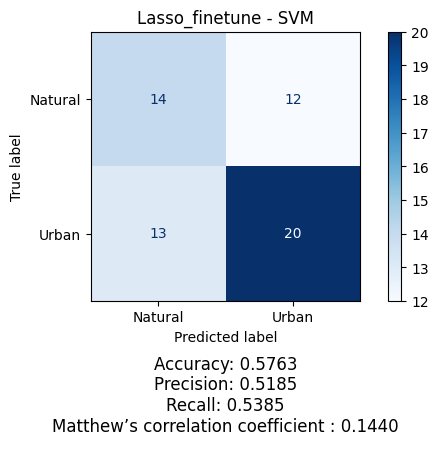

In [27]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [28]:
targetLabel=burn_label
X_lasso_burn,xlabel_lasso_burn = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
X_lasso_ft_burn,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)


Best alpha: 0.1


In [29]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso_burn,
               "Lasso_finetune":X_lasso_ft_burn,
               "Random":data
              }

In [30]:
print(np.shape(data))
print(np.shape(X_FS))
print(np.shape(X_lasso_burn))
print(np.shape(X_lasso_ft_burn))

(59, 1768)
(59, 203)
(59, 16)
(59, 12)


In [31]:
dict_cm_burn = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)

Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <clas

In [32]:
# Save dictionary to a pickle file
#with open('../results/dict_cm_smocky_burn.pkl', 'wb') as pickle_file:
#    pickle.dump(dict_cm_burn, pickle_file)
# Load dictionary from the pickle file
#with open('../results/dict_cm_smocky_burn.pkl', 'rb') as pickle_file:
#    dict_cm_burn = pickle.load(pickle_file)

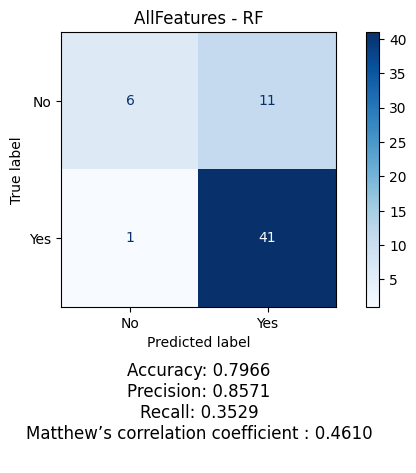

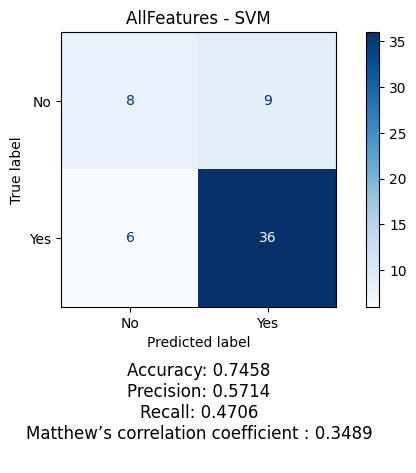

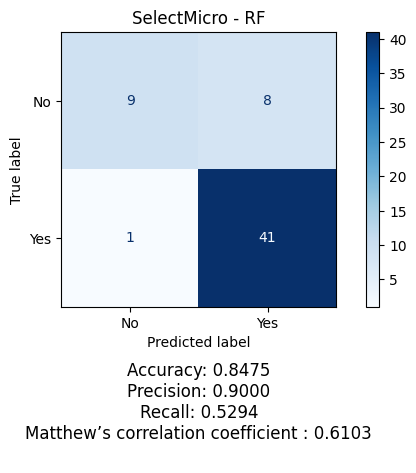

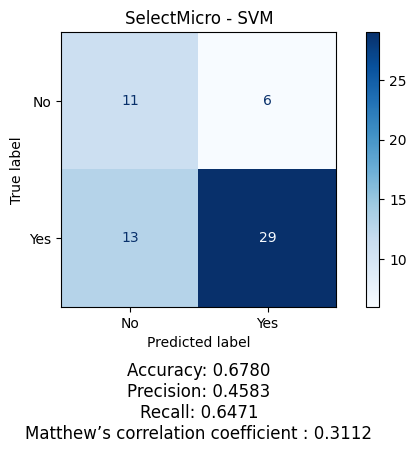

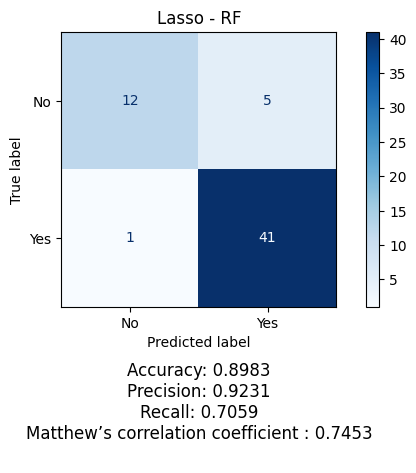

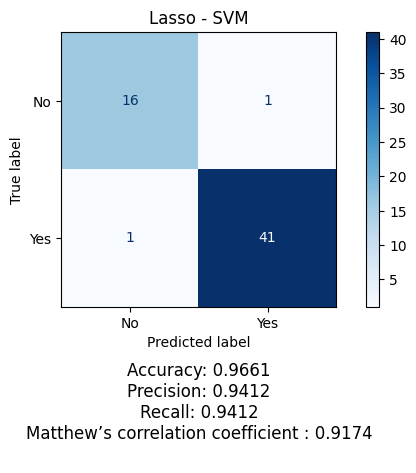

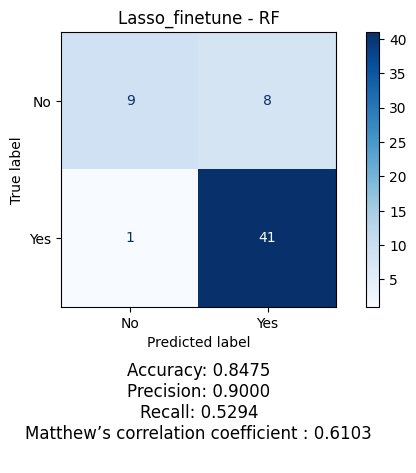

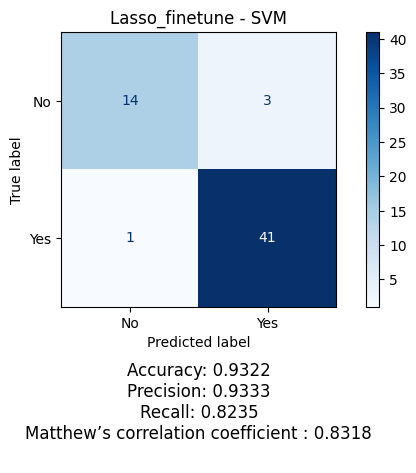

In [33]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm_burn.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [34]:
targetLabel=duration_label
X_lasso_dur,xlabel_lasso_dur = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
X_lasso_ft_dur,xlabel_lasso_ft_dur  = RunML_continue.LassoFS_CV(data,targetLabel)
print(xlabel_lasso_ft)

Best alpha: 0.1
[  7  64  72 108 109 110 154 166 224 416 476 502]


In [35]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso_dur,
               "Lasso_finetune":X_lasso_ft_dur,
               "Random":data
              }
print(np.shape(data))
print(np.shape(X_FS))
print(np.shape(X_lasso_dur))
print(np.shape(X_lasso_ft_dur))

(59, 1768)
(59, 203)
(59, 54)
(59, 9)


In [36]:
dict_cm_dur = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
# Save dictionary to a pickle file
#with open('../results/dict_cm_smocky_dur.pkl', 'wb') as pickle_file:
 #   pickle.dump(dict_cm_dur, pickle_file)
# Load dictionary from the pickle file
#with open('../results/dict_cm_smocky_dur.pkl', 'rb') as pickle_file:
 #   dict_cm_dur = pickle.load(pickle_file)

Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <clas

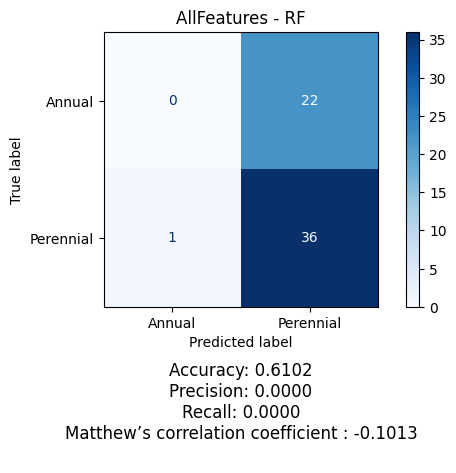

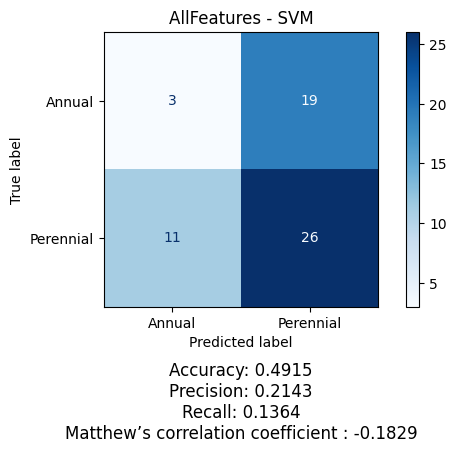

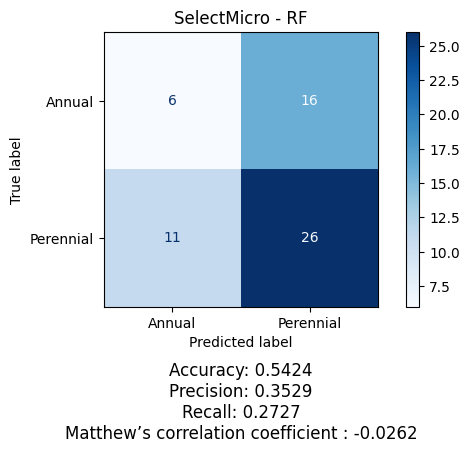

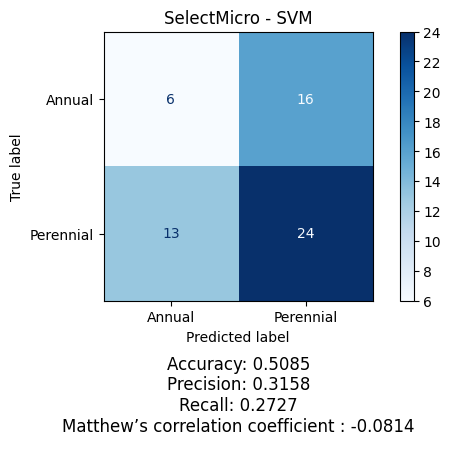

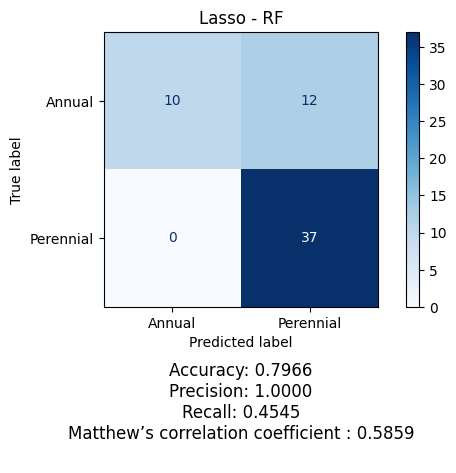

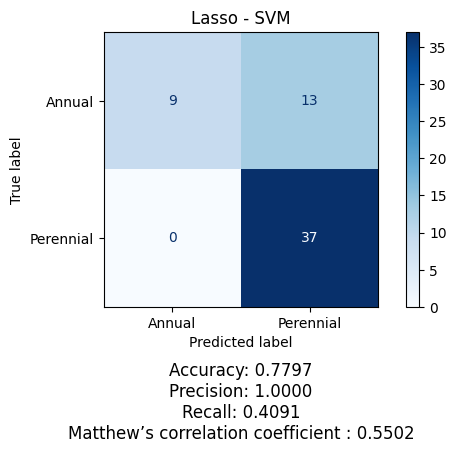

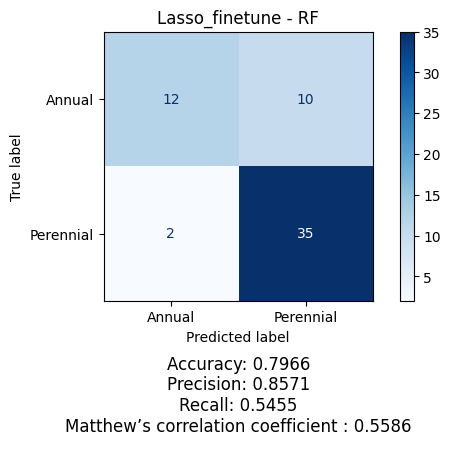

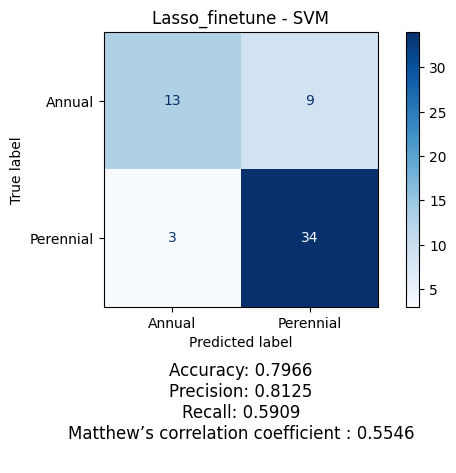

In [37]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm_dur.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

####  Model 2

##### Annual/ Perennial
For comparison, only use the selected features for Annual/ Perennial classification. 

Even though the performance of our method is still not as good as Lasso, but it gives us better prediction using only 19 features compared with the union selection which has 86 featues.

In [38]:
indices_3 = np.where(weights[2,:] > stats.chi2.ppf(1 - 0.1, 1))[0]

In [39]:
indices_3_sort = sorted(indices_3, key=lambda col: weights[2,col], reverse=True)

In [40]:
len(indices_3_sort)

26

In [41]:
X_FS_dur = data[:,indices_3_sort]

In [42]:
data_subset2 = {"AllFeatures":data, 
               "SelectMicro": X_FS_dur,
               "Lasso":X_lasso_dur,
               "Lasso_finetune":X_lasso_ft_dur,
               "Random":data
              }
print(np.shape(data))
print(np.shape(X_FS_dur))
print(np.shape(X_lasso_dur))
print(np.shape(X_lasso_ft_dur))

(59, 1768)
(59, 26)
(59, 54)
(59, 9)


In [43]:
dict_cm_dur2 = RunML_continue.runClassifier_FScompare(data_subsets= data_subset2,y= duration_label,N=iter,classifiers=cls,SMOTE=True)

Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <clas

##### burn
Let's also try it on burn label (expected to have better performance than Lasso, but ......)

So, we check the feature ratio for burn label.

In [44]:
weights[0,:]
indices_1 = np.where(weights[0,:] > stats.chi2.ppf(1 - 0.1, 1))[0]
indices_1_sort = sorted(indices_1, key=lambda col: weights[0,col], reverse=True)
len(indices_1_sort)

X_FS_burn = data[:,indices_1_sort]
X_lasso = data[:,xlabel_lasso_burn]

In [45]:
data_subset3 = {"AllFeatures":data, 
               "SelectMicro": X_FS_burn,
               "Lasso":X_lasso_burn,
               "Lasso_finetune":X_lasso_ft_burn,
               "Random":data
              }
print(np.shape(data))
print(np.shape(X_FS_burn))
print(np.shape(X_lasso))

(59, 1768)
(59, 141)
(59, 16)


In [46]:
dict_cm_burn2 = RunML_continue.runClassifier_FScompare(data_subsets= data_subset3,y= burn_label,N=iter,classifiers=cls,SMOTE=True)

Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <class 'list'>
Key: mean_accuracy, Type: <class 'numpy.float64'>
Key: mean_auc, Type: <class 'numpy.float64'>
Key: y_true, Type: <class 'list'>
Key: y_pred, Type: <class 'list'>
Key: y_pred_prob, Type: <clas

In [47]:
targetLabel=burn_label
print(set(targetLabel))
selectedASV1 = [ASVs[i] for i in indices_1_sort]
selectedASV1_lasso = [ASVs[i] for i in xlabel_lasso_burn]
FS.plotPresenseRatio(X_FS_burn,targetLabel,selectedASV1,posLabel="Yes",posText="Burned",negText="Not Burned",entries=len(selectedASV1))

{'Yes', 'No'}


TypeError: plotPresenseRatio() got an unexpected keyword argument 'entries'

In [ ]:
FS.plotPresenseRatio(X_lasso,targetLabel,selectedASV1_lasso,posLabel="Yes",posText="Burned",negText="Not Burned",entries=len(selectedASV1_lasso))


In [ ]:
print(np.asarray(selectedASV1))
print(np.asarray(selectedASV1_lasso))
print(np.isin(selectedASV1_lasso, selectedASV1))

#### Model3
To compare, also consider the union of the features selected by Lasso: the result shows that
1. for burn label, lasso's RF performance is worse, SVM is much better
2. for un_label,lasso's RF-accuracy SVM-AUC are better, RF-AUC and SVM-accuracy are worse.
3. for dur label, lasso's RF performance is worse, SVM-accuracy is worse SVM-AUC is  better

In [ ]:
# select the union of lasso feature selection
xlabel_lasso_union = pd.concat([pd.Series(xlabel_lasso), pd.Series(xlabel_lasso_burn), pd.Series(xlabel_lasso_dur)]).drop_duplicates().reset_index(drop=True)
len(xlabel_lasso_union)

In [ ]:
X_lasso_union = data[:,xlabel_lasso_union]
X_lasso_union.shape

In [ ]:
data_subset = {
    #"AllFeatures":data, 
            #   "SelectMicro": X_FS,
               "Lasso":X_lasso_union
              #, "Random":data
              }

print(np.shape(X_lasso_union))

In [ ]:
for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    dict_cm_lasso = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)
    for dataset_name, classifiers in dict_cm_lasso.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

### SHARP value
Compare the SHARP value of the significant features selected by our method and Lasso.(pending)

In [ ]:
#df_X_FS = pd.DataFrame(X_FS,columns=[ASVs[i] for i in selectedOTU_index] )
#df_X_FS.columns

In [ ]:
#RunML_continue.sharp_value(df_X_FS,burn_label,classifier_name)

In [ ]:
#df_X_lasso = pd.DataFrame(X_lasso_union,columns=[ASVs[i] for i in xlabel_lasso_union] )
#RunML_continue.sharp_value(df_X_lasso,burn_label,classifier_name)

### compare the first 15 index by their present ratio

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
selectedASVs_15=[ASVs[i] for i in selectedOTU_index_15]

X_FS_15=data[:,selectedOTU_index_15]


targetLabel=burn_label
print(set(targetLabel))
FS.plotPresenseRatio(X_FS_15,burn_label,selectedASVs_15,posLabel="Yes",posText="Burned",negText="Not Burned")

targetLabel=un_label
print(set(targetLabel))
FS.plotPresenseRatio(X_FS_15,un_label,selectedASVs_15,posLabel="Natural",posText="Natural",negText="Urban")


targetLabel=duration_label
print(set(targetLabel))
FS.plotPresenseRatio(X_FS_15,duration_label,selectedASVs_15,posLabel="Annual",posText="Annual",negText="Perennial")

In [ ]:
selectedASVs=[ASVs[i] for i in selectedOTU_index]

In [ ]:
print(np.asarray(selectedASVs))
print(len(selectedASVs))

### Negative Gini Impurity
Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset. It’s calculated as:

$G = 1- \sum_{i=1}^C p_i^2$

where C is the number of classes. (which means it can be used to measure for multiple level classification)

Here I will use the negative Gini Impurity to measure each OTU, if NG is large (1) which means the OTU only exist in one class, if NG value is small($1/c$) which means the OTU is evenly distributed among  the classes.

$NG = \sum_{i=1}^C p_i^2$

In [ ]:
# NG for selected OTU
NG_selected = metric.Neg_GINI(X_FS,yList)
print(NG_selected.shape)
# NG for Not selected OTU
X_FS_none = np.delete(data, selectedOTU_index, axis=1)
NG_noselected = metric.Neg_GINI(X_FS_none,yList)
print(NG_noselected.shape)

In [ ]:
label_lasso = [xlabel_lasso_burn,xlabel_lasso,xlabel_lasso_dur]

In [ ]:
ng_lasso_list = []
for i in range(len(y_index)):
    X_lasso_ng = data[:,label_lasso[i]]
    print(X_lasso_ng.shape)
    X_lasso_none_ng = np.delete(data, label_lasso[i], axis=1)
    print(X_lasso_none_ng.shape)
    Ng1 = metric.Neg_GINI(X_lasso_ng,np.transpose(yList)[i])
    Ng2 = metric.Neg_GINI(X_lasso_none_ng,np.transpose(yList)[i])
    ng_lasso_list.append([Ng1,Ng2])


#### Compare lasso and SelectMicro

In [ ]:
# Number of subplots
num_plots = len(y_index)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([NG_selected[i, :], ng_lasso_list[i][0]], tick_labels=['SelectMicro', 'Lasso'])
    plt.title(f'NG results of the selected OTU vs. non-selected OTUs - {y_index[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
    #print(len(NG_selected[i, :]))
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once

In [ ]:
# compare the selected and non select by our method
for i in range(len(y_index)):
    plt.figure(figsize=(4, 4))
    plt.boxplot([NG_selected[i,:], NG_noselected[i,:]], tick_labels=['SelectMicro', 'Not selected'])
    plt.title(f'NG results of the selected OTU vs. non selected OTUs by our method - {y_index[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
    
# Show the plot
plt.show()

In [ ]:
# compare the selected and non select by lasso
# Number of subplots
num_plots = len(y_index)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([ng_lasso_list[i][0], ng_lasso_list[i][1]], tick_labels=['Lasso', 'Not selected'])
    plt.title(f'NG results of the selected OTU vs. non-selected OTUs by Lasso - {y_index[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once

### Use LOOCV for fine tune model parameters and also the model's result

In [ ]:
targetLabel=burn_label
